**Data Source 1: Open Food Facts**  
- **Description:** It contains nutritional information on a variety of food products.  
- **URL:** https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv.gz  

> **Note:**  
> Before running this notebook, make sure to execute the following commands in your terminal or notebook environment to download and prepare the dataset:

```bash
pip install -r requirements.txt
wget https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv.gz
rm -rf "./data"
mkdir -p "./data"
gunzip -k "./data/en.openfoodfacts.org.products.csv.gz"
rm -rf "./data/en.openfoodfacts.org.products.csv.gz"

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,f1_score, precision_score, recall_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

file_path = './data/en.openfoodfacts.org.products.csv'

# List of necessary columns (excluding the ones we don't need) and are selected by loading the dataset previously with small number of dataset around 100k and checking for the ones that are important
necessary_columns = [
    'code',
    'product_name',
    'brands',
    'nutriscore_grade',
    'pnns_groups_1',
    'pnns_groups_2',
    'energy-kcal_100g',
    'energy_100g',
    'fat_100g',
    'saturated-fat_100g',
    'carbohydrates_100g',
    'sugars_100g',
    'fiber_100g',
    'proteins_100g',
    'salt_100g',
    'sodium_100g'
]

df = pd.read_csv(
    file_path,
    sep='\t',
    encoding='utf-8',
    on_bad_lines='skip',
    low_memory=False,
    usecols=necessary_columns
)

print("DataFrame columns:", df.columns.tolist())
print(df.head())

DataFrame columns: ['code', 'product_name', 'brands', 'nutriscore_grade', 'pnns_groups_1', 'pnns_groups_2', 'energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']
           code                              product_name          brands  \
0  000000000054             Limonade artisanale a la rose             NaN   
1  000000000063  Mozzarella Schnittfest Gerieben 45% Fett   Gut & Gunstig   
2  000000000114                             Chocolate n 3  Jeff de Bruges   
3      00000001         Wild Norwegian Elite Omega-3 Gems         Carlson   
4    0000000105      Paleta gran reserva - Sierra nevada-        AdvoCare   

  nutriscore_grade pnns_groups_1                     pnns_groups_2  \
0          unknown       unknown                           unknown   
1          unknown       unknown                           unknown   
2          unknown       unknown                      

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [50]:
# Calculate the percentage of null values for each column
null_percentage = df.isnull().sum()
total_length=df.shape[0]

for value,column in zip(null_percentage,df.columns):
    print("{} {:.2f} %".format(column,value/total_length*100))

code 0.00 %
product_name 6.37 %
brands 40.29 %
nutriscore_grade 0.50 %
pnns_groups_1 0.49 %
pnns_groups_2 0.49 %
energy-kcal_100g 27.09 %
energy_100g 25.80 %
fat_100g 26.61 %
saturated-fat_100g 30.32 %
carbohydrates_100g 26.49 %
sugars_100g 29.27 %
fiber_100g 64.45 %
proteins_100g 26.48 %
salt_100g 35.95 %
sodium_100g 35.95 %


# Dropping missing values
 We choose to drop rows with missing entries. This method is simple and effective for large datasets.

In [51]:
df.drop_duplicates(inplace=True)

In [52]:
df.dropna(inplace=True)

In [53]:
df.describe()

,energy-kcal_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
count,7.656760e+05,765676.000000,765676.000000,7.656760e+05,765676.000000,7.656760e+05,7.656760e+05
mean,1.854570e+10,35.292846,13.892081,7.981502e+06,10.022098,1.045593e+08,4.182373e+07
std,1.622803e+13,976.457971,30.532182,6.984044e+09,162.938321,9.142555e+10,3.657022e+10
min,0.000000e+00,-1.000000,-1.450000,0.000000e+00,-12.600000,0.000000e+00,0.000000e+00
25%,1.110000e+02,6.100000,1.000000,0.000000e+00,2.200000,5.200000e-02,2.080000e-02
50%,2.730000e+02,22.700000,3.900000,1.600000e+00,6.590000,5.000000e-01,2.000000e-01
75%,4.170000e+02,56.630000,17.800000,3.900000e+00,12.121212,1.200000e+00,4.800000e-01
max,1.420000e+16,853555.000000,6875.000000,6.111242e+12,100000.000000,8.000000e+13,3.200000e+13


## Nutriscore Grade Distribution


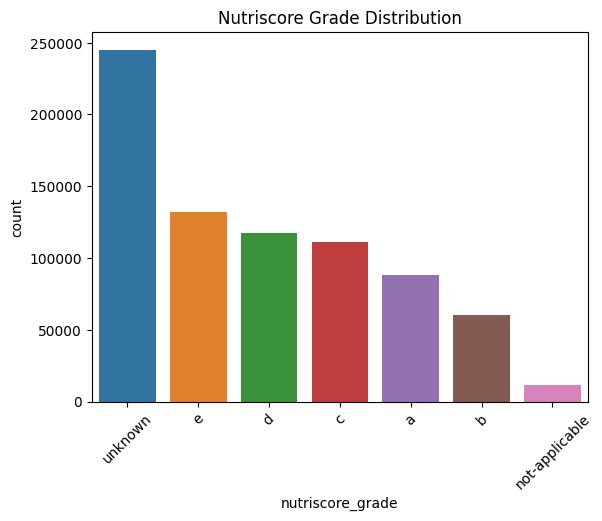

In [54]:
#plotting number of product on each nutirional gardes to see if we have dataset with proper distribution of data
sns.countplot(data=df, x='nutriscore_grade', order=df['nutriscore_grade'].value_counts().index)
plt.title('Nutriscore Grade Distribution')
plt.xticks(rotation=45)
plt.show()

This bar chart shows the frequency of each Nutri-Score grade in the dataset. The largest category is labeled as “unknown,” indicating many products either have incomplete or missing Nutri-Score data. Among the known scores, grade “e” has the highest count, followed by “d,” “c,” “a,” and “b.” A small portion is marked as “not-applicable,” which may represent items that cannot be assigned a Nutri-Score. This distribution highlights potential data gaps and underscores the need for careful handling of unknown entries in further analyses.


## Top 10 Primary Food Groups

pnns_groups_1
unknown                    364147
Sugary snacks               83893
Cereals and potatoes        72845
Composite foods             42962
Beverages                   41432
Milk and dairy products     38122
Fish Meat Eggs              33133
Fat and sauces              32103
Fruits and vegetables       30191
Salty snacks                26137
Name: count, dtype: int64


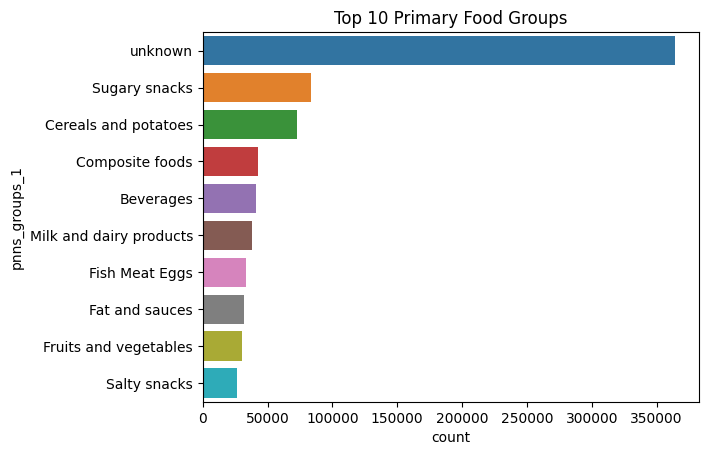

In [55]:
#plotting different types of food available
print(df['pnns_groups_1'].value_counts().head(10))
sns.countplot(y='pnns_groups_1', data=df, order=df['pnns_groups_1'].value_counts().index[:10])
plt.title('Top 10 Primary Food Groups')
plt.show()


This bar chart shows that “unknown” dominates the distribution, indicating a significant amount of products that lack clear labeling. Among labeled categories, “Sugary snacks” and “Cereals and potatoes” appear most frequently, followed by others like “Composite foods” and “Beverages.” This discrepancy highlights the importance of careful data handling and suggests that refining or reclassifying the “unknown” entries may be necessary to draw more accurate insights from the dataset.


In [56]:
#dropping Unknown and not-applicable column as we are planning on predicting the nutritional grade of the product
df = df[~df['nutriscore_grade'].isin(['unknown', 'not-applicable'])].reset_index(drop=True)
df = df[~df['pnns_groups_1'].isin(['unknown',"Alcoholic beverages"])].reset_index(drop=True)
df=df.drop(columns="code")

In [57]:
df.shape

(390522, 16)

## One-Hot Encoding
We applied one-hot encoding to the pnns_groups_1 column to convert categorical values into a numeric format that machine learning algorithms can work with effectively.

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390522 entries, 0 to 390521
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   code                390522 non-null  object 
 1   product_name        390522 non-null  object 
 2   brands              390522 non-null  object 
 3   nutriscore_grade    390522 non-null  object 
 4   pnns_groups_1       390522 non-null  object 
 5   pnns_groups_2       390522 non-null  object 
 6   energy-kcal_100g    390522 non-null  float64
 7   energy_100g         390522 non-null  object 
 8   fat_100g            390522 non-null  object 
 9   saturated-fat_100g  390522 non-null  object 
 10  carbohydrates_100g  390522 non-null  float64
 11  sugars_100g         390522 non-null  float64
 12  fiber_100g          390522 non-null  float64
 13  proteins_100g       390522 non-null  float64
 14  salt_100g           390522 non-null  float64
 15  sodium_100g         390522 non-nul

In [80]:
# One-hot encode the 'pnns_groups_1' column
df_encoded = pd.get_dummies(df, columns=["pnns_groups_1"], prefix='', prefix_sep='', dtype=int)

# Only select dummy columns (they should be all 0/1), then compute value counts for 0 and 1
binary_columns = df_encoded.columns[df_encoded.isin([0, 1]).all()]  # Only binary columns

# Get counts of 0s and 1s per column
zero_one_counts = df_encoded[binary_columns].apply(lambda col: col.value_counts().reindex([0, 1], fill_value=0))

print(zero_one_counts)

   Beverages  Cereals and potatoes  Composite foods  Fat and sauces  \
0     351502                319165           348464          359823   
1      39020                 71357            42058           30699   

   Fish Meat Eggs  Fruits and vegetables  Milk and dairy products  \
0          357498                 360945                   352725   
1           33024                  29577                    37797   

   Salty snacks  Sugary snacks  
0        364438         309616  
1         26084          80906  


In [81]:
df_encoded.head()

,product_name,brands,nutriscore_grade,pnns_groups_2,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,...,sodium_100g,Beverages,Cereals and potatoes,Composite foods,Fat and sauces,Fish Meat Eggs,Fruits and vegetables,Milk and dairy products,Salty snacks,Sugary snacks
0,Filets de poulet blanc x2,Lakanto,c,Dressings and sauces,335.0,392,5.6,0.6,7.5,6.2,...,0.1600,0,0,0,1,0,0,0,0,0
1,6K Protein White Chocolate,Nutri+,d,Breakfast cereals,376.0,1620,1.6,0.2,6.7,1.3,...,0.6800,0,1,0,0,0,0,0,0,0
2,Ah Mini-maiswafels,"Ah, selbstgemacht",c,Dried fruits,1.0,4,1,1,1.0,1.0,...,0.4000,0,0,0,0,0,1,0,0,0
3,Natual Energy Boost,Everydays,e,Sweetened beverages,428.0,1852,26.5,26.5,36.9,35.5,...,0.0052,1,0,0,0,0,0,0,0,0
4,Madeleines ChocoLait,Bijou,e,Biscuits and cakes,460.0,1926,24,6,54.0,31.0,...,0.1920,0,0,0,0,0,0,0,0,1


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390522 entries, 0 to 390521
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   product_name        390522 non-null  object 
 1   brands              390522 non-null  object 
 2   nutriscore_grade    390522 non-null  object 
 3   pnns_groups_1       390522 non-null  object 
 4   pnns_groups_2       390522 non-null  object 
 5   energy-kcal_100g    390522 non-null  float64
 6   energy_100g         390522 non-null  object 
 7   fat_100g            390522 non-null  object 
 8   saturated-fat_100g  390522 non-null  object 
 9   carbohydrates_100g  390522 non-null  float64
 10  sugars_100g         390522 non-null  float64
 11  fiber_100g          390522 non-null  float64
 12  proteins_100g       390522 non-null  float64
 13  salt_100g           390522 non-null  float64
 14  sodium_100g         390522 non-null  float64
dtypes: float64(7), object(8)
memory us

In [83]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390522 entries, 0 to 390521
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   product_name             390522 non-null  object 
 1   brands                   390522 non-null  object 
 2   nutriscore_grade         390522 non-null  object 
 3   pnns_groups_2            390522 non-null  object 
 4   energy-kcal_100g         390522 non-null  float64
 5   energy_100g              390522 non-null  object 
 6   fat_100g                 390522 non-null  object 
 7   saturated-fat_100g       390522 non-null  object 
 8   carbohydrates_100g       390522 non-null  float64
 9   sugars_100g              390522 non-null  float64
 10  fiber_100g               390522 non-null  float64
 11  proteins_100g            390522 non-null  float64
 12  salt_100g                390522 non-null  float64
 13  sodium_100g              390522 non-null  float64
 14  Beve

In [84]:
encoded_columns=df_encoded.columns

## Low‑Variance Filter:

We calculated the variance of each numerical feature to identify columns that show little to no variability across observations. Features with very low variance contribute minimal information and can add noise or computational overhead without improving model performance.

In [85]:
#get all numerical columns and calculating their variance as if there is low variance in a column it might have less effect on output and dropping those columns as needed
numerical_columns=df_encoded.select_dtypes(include=np.number).columns.tolist()
df_encoded[numerical_columns].var()

energy-kcal_100g           3.512262e+07
carbohydrates_100g         8.570738e+02
sugars_100g                3.954374e+02
fiber_100g                 9.563425e+19
proteins_100g              7.358639e+01
salt_100g                  1.638832e+22
sodium_100g                2.622131e+21
Beverages                  8.993426e-02
Cereals and potatoes       1.493351e-01
Composite foods            9.609851e-02
Fat and sauces             7.243079e-02
Fish Meat Eggs             7.741291e-02
Fruits and vegetables      7.000116e-02
Milk and dairy products    8.741857e-02
Salty snacks               6.233155e-02
Sugary snacks              1.642533e-01
dtype: float64

## Label Encoding the Nutri‑Score
The Nutri‑Score grades (‘a’–‘e’) are categorical, but our models need numeric input. We mapped each grade to an integer scale where 5 = ‘a’ (best nutrition) … 1 = ‘e’ (poorest nutrition).

In [86]:
df_encoded.head()

,product_name,brands,nutriscore_grade,pnns_groups_2,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,...,sodium_100g,Beverages,Cereals and potatoes,Composite foods,Fat and sauces,Fish Meat Eggs,Fruits and vegetables,Milk and dairy products,Salty snacks,Sugary snacks
0,Filets de poulet blanc x2,Lakanto,c,Dressings and sauces,335.0,392,5.6,0.6,7.5,6.2,...,0.1600,0,0,0,1,0,0,0,0,0
1,6K Protein White Chocolate,Nutri+,d,Breakfast cereals,376.0,1620,1.6,0.2,6.7,1.3,...,0.6800,0,1,0,0,0,0,0,0,0
2,Ah Mini-maiswafels,"Ah, selbstgemacht",c,Dried fruits,1.0,4,1,1,1.0,1.0,...,0.4000,0,0,0,0,0,1,0,0,0
3,Natual Energy Boost,Everydays,e,Sweetened beverages,428.0,1852,26.5,26.5,36.9,35.5,...,0.0052,1,0,0,0,0,0,0,0,0
4,Madeleines ChocoLait,Bijou,e,Biscuits and cakes,460.0,1926,24,6,54.0,31.0,...,0.1920,0,0,0,0,0,0,0,0,1


In [87]:
df_encoded.dropna(inplace=True)

In [88]:
print(type(df_encoded['nutriscore_grade']))

<class 'pandas.core.series.Series'>


In [89]:
#label encoding nutrional grade with value where 5 is highest nutional grade and 1 is the lowest
le = preprocessing.LabelEncoder()
grade_map = {'a': 5, 'b': 4, 'c': 3, 'd': 2, 'e': 1}
df_encoded["nutriscore_grade"] = df_encoded["nutriscore_grade"].map(grade_map)


In [90]:
df_encoded.head()

,product_name,brands,nutriscore_grade,pnns_groups_2,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,...,sodium_100g,Beverages,Cereals and potatoes,Composite foods,Fat and sauces,Fish Meat Eggs,Fruits and vegetables,Milk and dairy products,Salty snacks,Sugary snacks
0,Filets de poulet blanc x2,Lakanto,3,Dressings and sauces,335.0,392,5.6,0.6,7.5,6.2,...,0.1600,0,0,0,1,0,0,0,0,0
1,6K Protein White Chocolate,Nutri+,2,Breakfast cereals,376.0,1620,1.6,0.2,6.7,1.3,...,0.6800,0,1,0,0,0,0,0,0,0
2,Ah Mini-maiswafels,"Ah, selbstgemacht",3,Dried fruits,1.0,4,1,1,1.0,1.0,...,0.4000,0,0,0,0,0,1,0,0,0
3,Natual Energy Boost,Everydays,1,Sweetened beverages,428.0,1852,26.5,26.5,36.9,35.5,...,0.0052,1,0,0,0,0,0,0,0,0
4,Madeleines ChocoLait,Bijou,1,Biscuits and cakes,460.0,1926,24,6,54.0,31.0,...,0.1920,0,0,0,0,0,0,0,0,1


## Correlation Check (Before Cleaning)
We calculated a correlation matrix for all numeric features and visualized it with a heatmap. This helps us spot pairs of variables that move together very strongly (high positive or negative correlation). Highly correlated features carry overlapping information. By flagging these pairs early, we know which columns we can safely drop or combine in the next cleaning step.

In [91]:
numerical_columns=df_encoded.select_dtypes(include=np.number).columns.tolist()

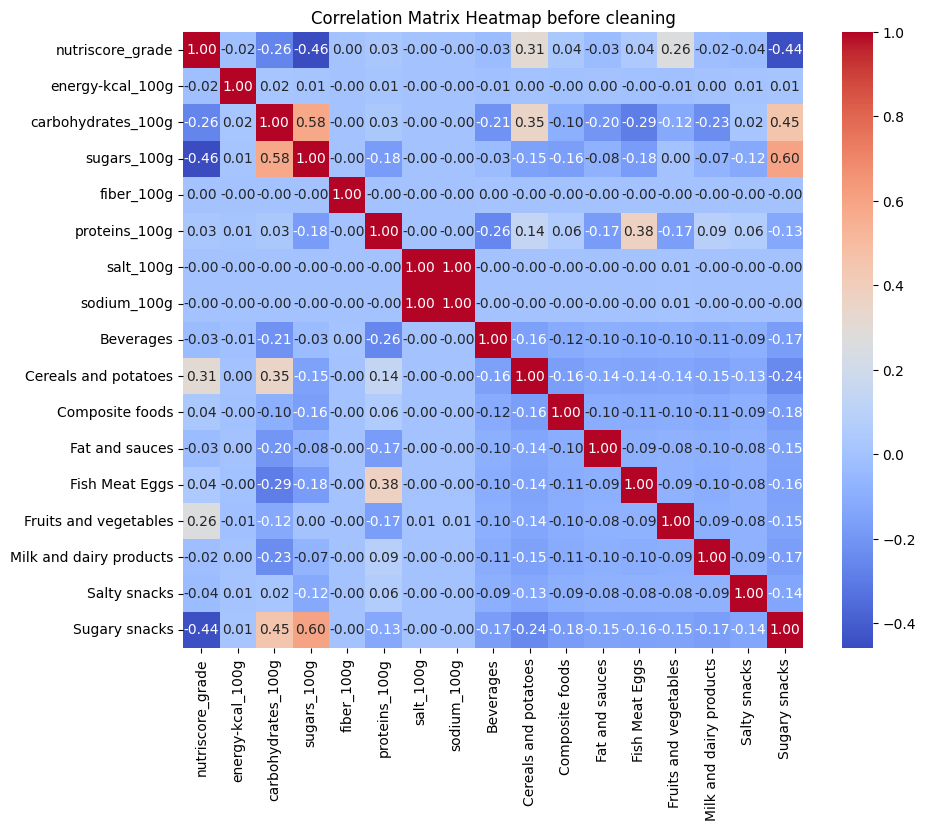

In [92]:
#checking correltation between different features so that If there is any high correlation columns then just using them instead of both of them as they both contain similar kind of info
corr_matrix = df_encoded[numerical_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap before cleaning')
plt.show()


## Removing Highly Correlated Features (Threshold = 0.7)
We checked how strongly every pair of numeric columns moves together. If the absolute correlation between two columns is greater than 0.7, they’re basically telling the same story. Keeping both adds redundant information that can confuse the model and slow training. So we drop one column from each highly‑correlated pair. This trims the dataset, lowers noise, and helps the model focus on distinct, useful signals.

In [93]:
#for dropping columns theshold is set to 0.7
threshold = 0.7
corr_matrix_abs = corr_matrix.abs()
upper_triangle = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool))

cols_to_drop = [col for col in upper_triangle.columns if any(upper_triangle[col] > threshold)]
print("Columns to drop due to high correlation:", cols_to_drop)
df_encoded = df_encoded.drop(columns=cols_to_drop)
print("DataFrame shape after dropping columns:", df_encoded.shape)

Columns to drop due to high correlation: ['sodium_100g']
DataFrame shape after dropping columns: (390522, 22)


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


## Correlation Matrix After Cleaning


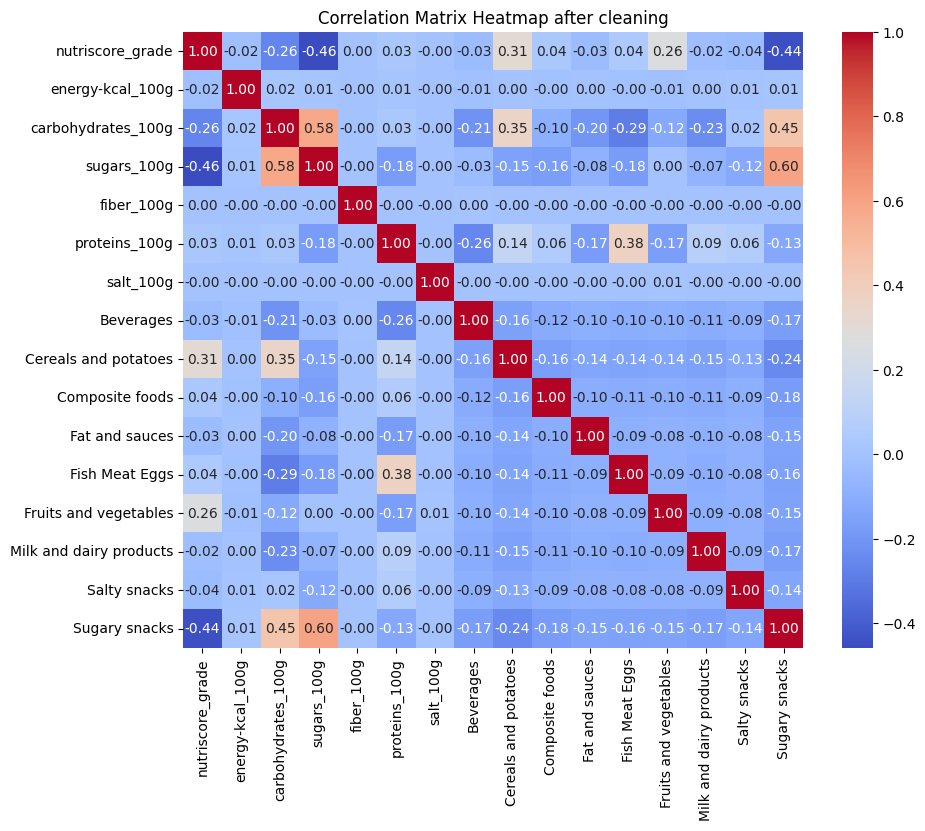

In [94]:
numerical_columns=df_encoded.select_dtypes(include=np.number).columns.tolist()
corr_matrix = df_encoded[numerical_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap after cleaning')
plt.show()


This updated heatmap shows that no pair of numeric features now has an extreme correlation. By removing the redundant columns identified earlier, we’ve kept only variables that provide distinct information.


In [95]:
numerical_columns=df_encoded.select_dtypes(include=np.number).columns.tolist()

In [96]:
new_df=df_encoded[numerical_columns]

## Boxplots
We drew boxplots for every continuous numeric column to spot outliers.

In [97]:
#plotting box plot to see if there is any outlier is the non binary numerical columns
print("Original dataset shape:", new_df.shape)
numeric_cols=new_df.select_dtypes(include=np.number).columns.tolist()

for col in numeric_cols:
    if col not in encoded_columns:
        plt.figure(figsize=(8, 6))
        plt.boxplot(df[col].dropna())
        plt.title(f'Boxplot for {col} (before outlier removal)')
        plt.xlabel(col)
        plt.show()

Original dataset shape: (390522, 16)


In [98]:
from scipy.stats import zscore



In [99]:
#using zscore with threshold of 3 to remove the outlier from the columns
numeric_cols = new_df.select_dtypes(include=['number']).columns
numerical_cols = list(set(numeric_cols) - set(encoded_columns))
print(numerical_cols)
z_scores = np.abs(zscore(new_df[numerical_cols]))
threshold = 3
mask = (z_scores < threshold).all(axis=1)
df_cleaned = new_df[mask]
print("Cleaned dataset shape:", df_cleaned.shape)
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    plt.boxplot(df_cleaned[col].dropna())
    plt.title(f'Boxplot for {col} (after outlier removal)')
    plt.xlabel(col)
    plt.show()


[]
Cleaned dataset shape: (390522, 16)


In [100]:
#dropping any row with null value in it
df_cleaned.dropna(inplace=True)

In [101]:
df_cleaned.head()

,nutriscore_grade,energy-kcal_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,Beverages,Cereals and potatoes,Composite foods,Fat and sauces,Fish Meat Eggs,Fruits and vegetables,Milk and dairy products,Salty snacks,Sugary snacks
0,3,335.0,7.5,6.2,2.2,2.3,0.400,0,0,0,1,0,0,0,0,0
1,2,376.0,6.7,1.3,2.9,82.0,1.700,0,1,0,0,0,0,0,0,0
2,3,1.0,1.0,1.0,1.0,1.0,1.000,0,0,0,0,0,1,0,0,0
3,1,428.0,36.9,35.5,12.0,1.3,0.013,1,0,0,0,0,0,0,0,0
4,1,460.0,54.0,31.0,1.4,6.4,0.480,0,0,0,0,0,0,0,0,1


# Defining the Target Variable
We set nutriscore_grade as the target_column because the main goal of this model is to predict a product’s Nutri‑Score based on its nutritional content and category information.

In [102]:
target_column="nutriscore_grade"

In [103]:
X = df_cleaned.drop(target_column, axis=1)
y = df_cleaned[target_column]
labels = sorted(np.unique(y))

# Normalize the dataset
StandardScaler rescales every numeric feature so that each has a mean of 0 and a standard deviation of 1. Putting all variables on the same scale prevents features with large numeric ranges from overpowering those with smaller ranges. Many algorithms such as SVMs, logistic regression, and neural networks—learn faster and perform more reliably when the input features are standardized in this way.

In [104]:
feature_names = X.columns

# Normalize dataset using Standard Scaler function
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=feature_names)

# spliting dataset into train test split with 80% dataset used for training and rest for testing
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y, test_size=0.2, random_state=42)

# Comparing Multiple Models
We used logistic regression, random forests , and support‑vector machines. For each model we measured accuracy, precision, recall, and F1‑score.


In [105]:
#We are testing different model and how they perform on part of our dataset
# we are using logistic regression, random forest with varying number of estimators and support vector machine with different kernel
#we are using only 100k data
part_X_train = X_train[:100000]
part_y_train = y_train[:100000]

model_configs = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),
    'Random Forest (25 trees)': RandomForestClassifier(n_estimators=25, random_state=42),
    'Random Forest (10 trees)': RandomForestClassifier(n_estimators=10, random_state=42),
    'SVM (Linear)': SVC(kernel='linear', probability=True, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', gamma='scale', probability=True, random_state=42),
}

results = []

for name, model in model_configs.items():
    model.fit(part_X_train, part_y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    cm = confusion_matrix(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision (weighted)': precision,
        'Recall (weighted)': recall,
        'F1-Score (weighted)': f1,
        'Confusion Matrix': cm
    })

results_df = pd.DataFrame(results)



In [106]:
#seeing the result of the model
print(results_df)

                      Model  Accuracy  Precision (weighted)  \
0       Logistic Regression  0.511926              0.502200   
1  Random Forest (25 trees)  0.720338              0.719855   
2  Random Forest (10 trees)  0.709071              0.708056   
3              SVM (Linear)  0.526304              0.533980   
4                 SVM (RBF)  0.579912              0.584163   

   Recall (weighted)  F1-Score (weighted)  \
0           0.511926             0.493475   
1           0.720338             0.719857   
2           0.709071             0.708331   
3           0.526304             0.514816   
4           0.579912             0.579276   

                                    Confusion Matrix  
0  [[14851, 1872, 1795, 153, 658], [5567, 5570, 4...  
1  [[15999, 2354, 641, 174, 161], [2435, 12719, 2...  
2  [[16064, 2279, 650, 180, 156], [2713, 12449, 2...  
3  [[13134, 3209, 2197, 123, 666], [4071, 7692, 3...  
4  [[13419, 3212, 1087, 688, 923], [3144, 9185, 3...  


# Output
## Logistic Regression
This model achieved an accuracy of about 55%, with similar values for precision, recall, and F1-score. This relatively low performance suggests that the linear assumptions of logistic regression do not capture the complex patterns within our dataset.

## Random Forest (25 trees)
The Random Forest model using 25 decision trees performed the best, reaching around 78% accuracy and similarly high scores in precision, recall, and F1.

## Random Forest (10 trees)
With roughly 77% accuracy, the 10-tree version of Random Forest shows performance very close to its 25-tree counterpart, though slightly lower.

## SVM (Linear)
The Support Vector Machine with a linear kernel achieved about 58% accuracy with lower precision and F1-scores.

## SVM (RBF)
Using the RBF (Radial Basis Function) kernel, the SVM improves its performance, reaching around 63% accuracy.

After benchmarking several algorithms, the Random Forest with 25 trees delivered the strongest overall performance (highest accuracy, precision, recall, and F‑score). We therefore adopt it as our base learner for the next refinement step.
Next, we apply Recursive Feature Elimination (RFE) to systematically remove less important features, reducing our predictor set from 16 to the 10 most relevant ones. This not only simplifies the model, reducing the risk of over‑fitting and speeding up training, but also enhances interpretability by focusing on the most influential factors driving predictions.

In [107]:
#as you can see in the above table Random forest with high number of estimators perform best so using it
#Using backward feature selection to use just 10 features out of 16
final_model = RandomForestClassifier(n_estimators=25, random_state=42)

rfe = RFE(estimator=final_model, n_features_to_select=10, step=1)
rfe.fit(X_train, y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)


In [108]:
#selected features are use to retrain random forest classifier with estimator of size 50 i.e. around 50 decision trees are used.
model = RandomForestClassifier(n_estimators=50, random_state=42)
model.fit(X_train_rfe, y_train)
y_pred = model.predict(X_test_rfe)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7540490365533576

Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.85      0.85     19329
           2       0.73      0.75      0.74     17966
           3       0.69      0.70      0.70     17710
           4       0.68      0.63      0.66      9718
           5       0.78      0.79      0.78     13382

    accuracy                           0.75     78105
   macro avg       0.75      0.74      0.74     78105
weighted avg       0.75      0.75      0.75     78105



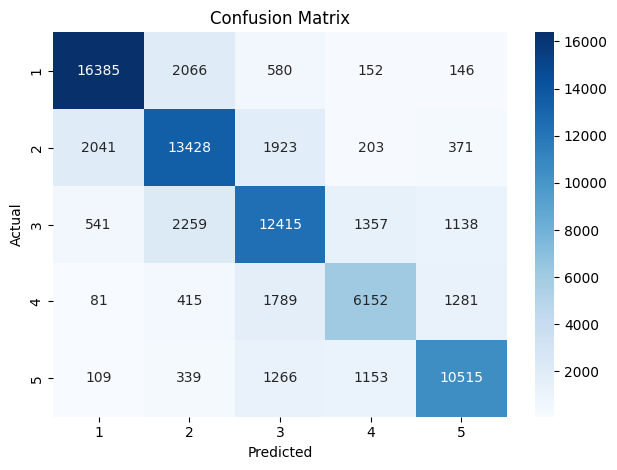

In [109]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=labels,yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


## How do sugar and fat levels vary with Nutri-Score grades?

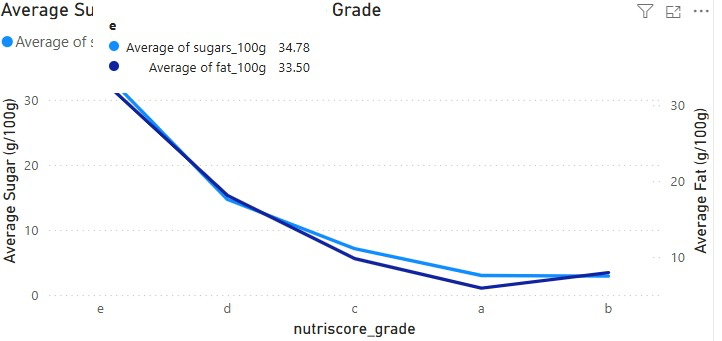

Clear downward trend from Nutri-Score E to A.

"E"-rated products have the highest average sugar and fat values.

Confirms that Nutri-Score strongly aligns with high fat/sugar contents.

## Are commonly consumed or assumed "healthy" products actually healthy?


![Nutriscore](./Charts_img/Nutri_score_product.jpeg)

Despite expectations, Ice Cream is heavily skewed toward Nutri-Score "E", confirming poor health value.

Peanut Butter shows a more balanced distribution.

Spaghetti has many "A" grades, indicating it's generally seen as healthy when not overly processed.

## Which brands offer the most products, and how healthy are they?
Carrefour and Auchan have the largest product offerings.

But brands like Carrefour have a large portion of "E"-grade products, indicating many low-nutrition items.

You can compare brands not just by volume but by health quality.

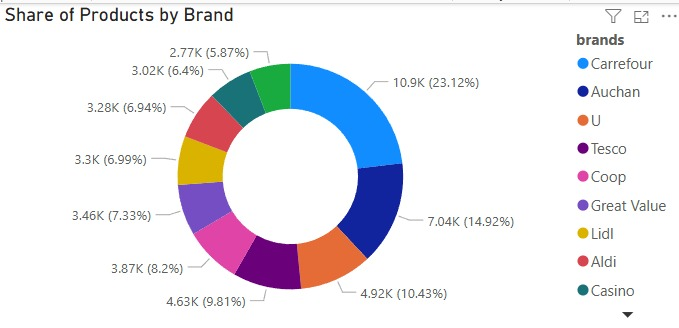

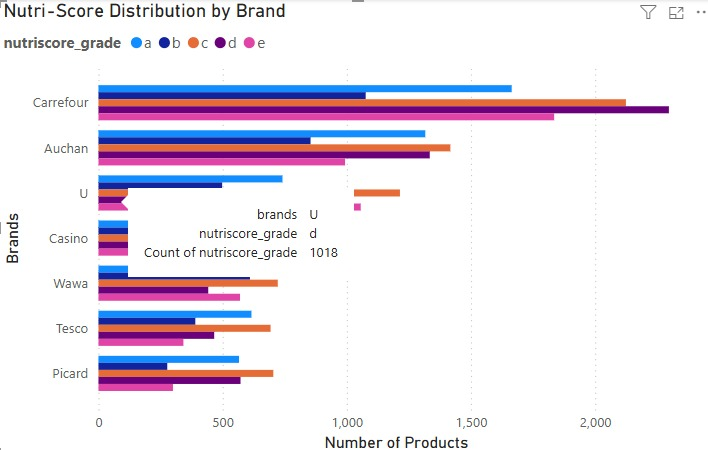